In [30]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)


def generate_realistic_intraday_data(ticker='NVDA', num_minutes=600, initial_price=140.0):

    #Generating realistic 1-minute intraday data with momentum patterns

    print(f"Generating {num_minutes} minutes of realistic market data for {ticker}")

    #timestamp index
    start_time = datetime.now().replace(hour=9, minute=30, second=0, microsecond=0)
    timestamps = [start_time + timedelta(minutes=i) for i in range(num_minutes)]


    prices = [initial_price]

    # momentum regime switches
    regime_length = 30  # Average regime length in minutes
    momentum_strength = 0.0

    for i in range(1, num_minutes):

        if np.random.random() < 1/regime_length:
            momentum_strength = np.random.uniform(-0.002, 0.003)  # -0.2% to +0.3% per minute

        #trend component (momentum) + noise
        trend = momentum_strength * prices[-1]
        noise = np.random.normal(0, 0.0015) * prices[-1]  # 0.15% volatility

        # Mean reversion
        mean_price = np.mean(prices[-10:]) if len(prices) >= 10 else prices[-1]
        reversion = -0.05 * (prices[-1] - mean_price)

        new_price = prices[-1] + trend + noise + reversion
        prices.append(max(new_price, initial_price * 0.95))  # Price floor

    # OHLC data
    data = []
    for i, (timestamp, close) in enumerate(zip(timestamps, prices)):

        volatility = close * 0.001
        high = close + abs(np.random.normal(0, volatility))
        low = close - abs(np.random.normal(0, volatility))
        open_price = prices[i-1] if i > 0 else close


        base_volume = 50000
        volume_multiplier = 1 + abs(momentum_strength) * 100
        volume = int(base_volume * volume_multiplier * np.random.uniform(0.8, 1.2))

        data.append({
            'Open': open_price,
            'High': max(open_price, high, close),
            'Low': min(open_price, low, close),
            'Close': close,
            'Volume': volume
        })

    df = pd.DataFrame(data, index=timestamps)
    df['Midpoint'] = (df['High'] + df['Low']) / 2

    print(f"Generated {len(df)} data points")
    print(f"Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
    print(f"Price change: {((df['Close'].iloc[-1] / df['Close'].iloc[0]) - 1) * 100:.2f}%")

    return df


#momentum signal generation

def calculate_rsi(prices, period=14):

    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_ema_slope(prices, ema_period=10, slope_window=5):

    ema = prices.ewm(span=ema_period, adjust=False).mean()

    # Calculating slope using linear regression over rolling window
    slopes = []
    for i in range(len(ema)):
        if i < slope_window:
            slopes.append(0)
        else:
            y = ema.iloc[i-slope_window:i].values
            x = np.arange(slope_window)
            slope = np.polyfit(x, y, 1)[0]
            slopes.append(slope)

    return pd.Series(slopes, index=ema.index)

def generate_momentum_signal(data, rsi_period=14, ema_period=10):

    #Generating composite momentum signal combining RSI and EMA slope

    rsi = calculate_rsi(data['Close'], period=rsi_period)
    ema_slope = calculate_ema_slope(data['Close'], ema_period=ema_period)

    rsi_normalized = (rsi - 50) / 50

    # Normalizing EMA slope
    ema_slope_normalized = (ema_slope - ema_slope.mean()) / (ema_slope.std() + 1e-8)
    ema_slope_normalized = np.clip(ema_slope_normalized, -1, 1)

    momentum_signal = 0.6 * rsi_normalized + 0.4 * ema_slope_normalized

    return momentum_signal, rsi, ema_slope


def simulate_static_vwap(data, order_size=50000, execution_minutes=120):

    print("Simulating Static VWAP Execution")

    execution_data = data.head(execution_minutes).copy()

    # Equal slicing
    shares_per_slice = order_size / execution_minutes

    execution_log = []
    for idx, row in execution_data.iterrows():
        execution_log.append({
            'timestamp': idx,
            'shares': shares_per_slice,
            'price': row['Midpoint'],
            'cost': shares_per_slice * row['Midpoint']
        })

    execution_df = pd.DataFrame(execution_log)

    # average execution price
    avg_price = execution_df['cost'].sum() / order_size

    print(f"Shares executed: {order_size:,.0f}")
    print(f"Average execution price: ${avg_price:.2f}")

    return execution_df, avg_price

def simulate_momentum_adjusted(data, momentum_signal, order_size=50000,
                               execution_minutes=120, min_rate=0.5, max_rate=2.0):

    print("Simulating Momentum-Adjusted Execution")

    execution_data = data.head(execution_minutes).copy()
    signal_data = momentum_signal.head(execution_minutes)

    # Convert momentum signal to participation rate multiplier
    participation_rates = min_rate + (signal_data + 1) / 2 * (max_rate - min_rate)

    raw_shares = participation_rates * (order_size / execution_minutes)
    shares_allocation = raw_shares * (order_size / raw_shares.sum())

    execution_log = []
    total_executed = 0

    for idx, row in execution_data.iterrows():
        shares_to_execute = shares_allocation.loc[idx]

        if total_executed + shares_to_execute > order_size:
            shares_to_execute = order_size - total_executed

        if shares_to_execute > 0:
            execution_log.append({
                'timestamp': idx,
                'shares': shares_to_execute,
                'price': row['Midpoint'],
                'cost': shares_to_execute * row['Midpoint'],
                'momentum': signal_data.loc[idx],
                'participation_rate': participation_rates.loc[idx]
            })

            total_executed += shares_to_execute

            if total_executed >= order_size:
                break

    execution_df = pd.DataFrame(execution_log)

    # average execution price
    avg_price = execution_df['cost'].sum() / total_executed

    print(f"Shares executed: {total_executed:,.0f}")
    print(f"Average execution price: ${avg_price:.2f}")
    print(f"Avg participation rate: {execution_df['participation_rate'].mean():.2f}x")
    print(f"Max participation rate: {execution_df['participation_rate'].max():.2f}x")
    print(f"Min participation rate: {execution_df['participation_rate'].min():.2f}x")

    return execution_df, avg_price



Generating 600 minutes of realistic market data for NVDA
Generated 600 data points
Price range: $136.99 - $163.94
Price change: 11.62%

Generating momentum signals
Decision price (T=0): $140.00
Simulating Static VWAP Execution
Shares executed: 50,000
Average execution price: $151.63
Simulating Momentum-Adjusted Execution
Shares executed: 50,000
Average execution price: $151.48
Avg participation rate: 1.61x
Max participation rate: 2.00x
Min participation rate: 0.71x
TCA - Report


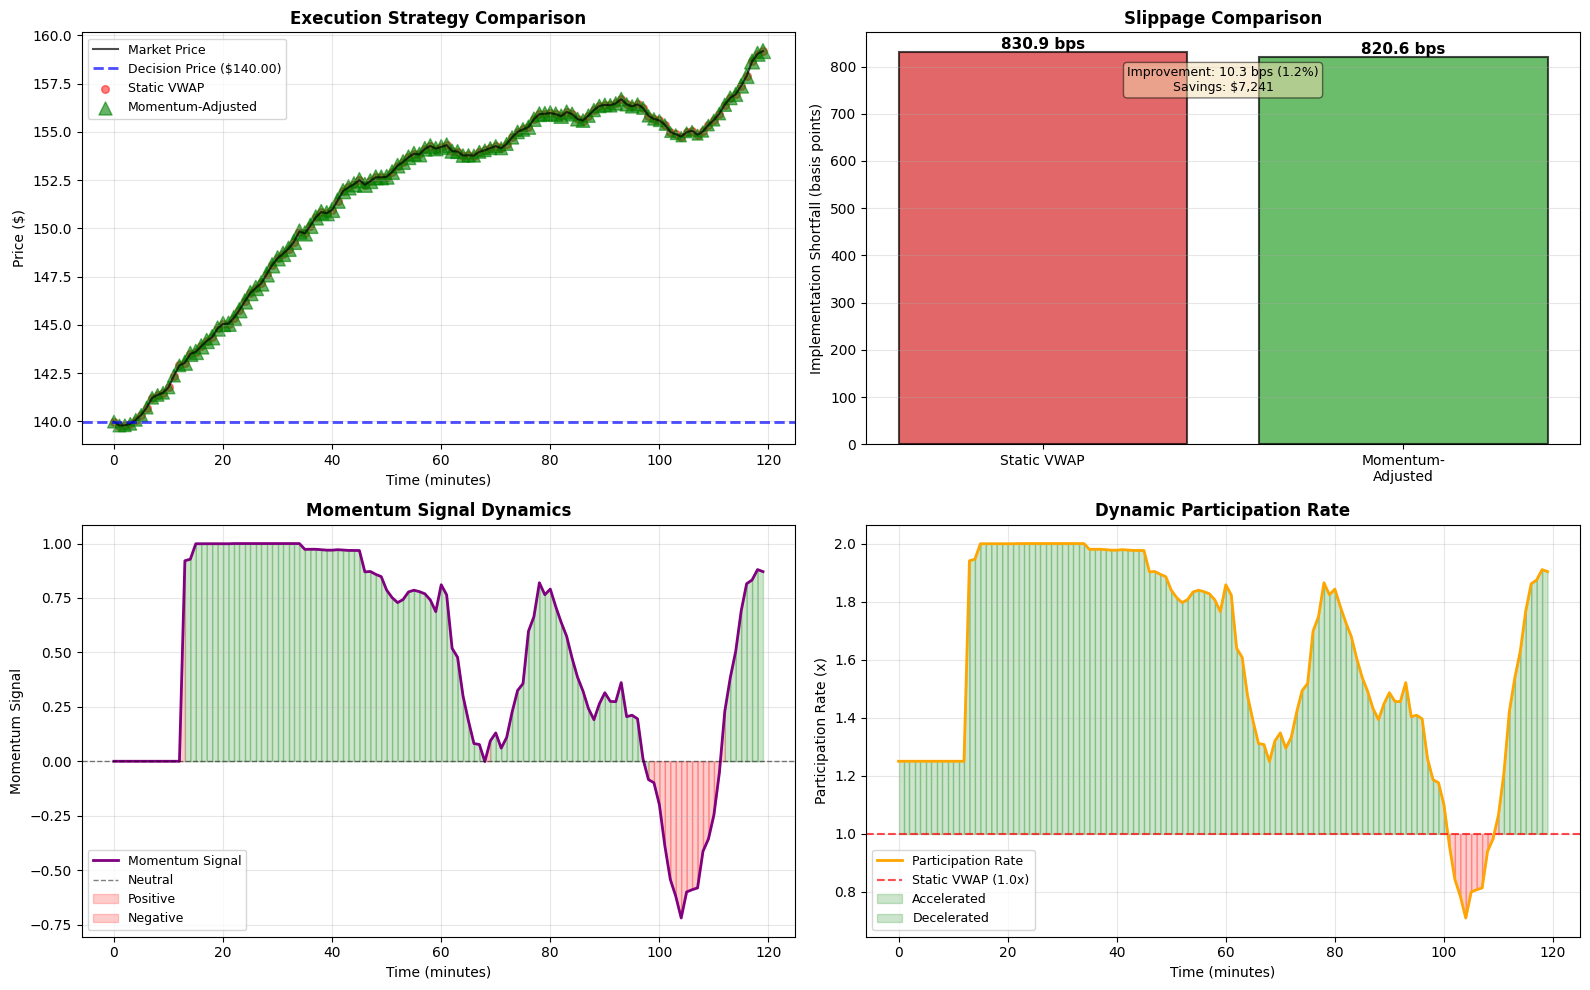

In [31]:


def calculate_implementation_shortfall(decision_price, avg_execution_price):

    is_ratio = (avg_execution_price - decision_price) / decision_price
    is_bps = is_ratio * 10000
    return is_bps

def generate_performance_report(static_exec, momentum_exec, decision_price):

    print("TCA - Report")

    static_df, static_avg_price = static_exec
    momentum_df, momentum_avg_price = momentum_exec

    # Calculating Implementation Shortfall
    static_is = calculate_implementation_shortfall(decision_price, static_avg_price)
    momentum_is = calculate_implementation_shortfall(decision_price, momentum_avg_price)

    # Calculating improvement
    improvement_bps = static_is - momentum_is
    improvement_pct = (improvement_bps / static_is) * 100 if static_is != 0 else 0

    # Dollar impact
    order_size = static_df['shares'].sum()
    dollar_savings = (static_avg_price - momentum_avg_price) * order_size



    return {
        'static_is_bps': static_is,
        'momentum_is_bps': momentum_is,
        'improvement_bps': improvement_bps,
        'improvement_pct': improvement_pct,
        'static_avg_price': static_avg_price,
        'momentum_avg_price': momentum_avg_price,
        'dollar_savings': dollar_savings
    }


#charts
def create_visualizations(data, static_exec, momentum_exec, decision_price, metrics):

    static_df, _ = static_exec
    momentum_df, _ = momentum_exec

    fig = plt.figure(figsize=(16, 10))


    # Price Action with Execution Markers

    ax1 = plt.subplot(2, 2, 1)

    # Plot price
    execution_window = data.head(120)
    ax1.plot(range(len(execution_window)), execution_window['Midpoint'].values,
             color='black', linewidth=1.5, label='Market Price', alpha=0.7)

    # Decision price line
    ax1.axhline(y=decision_price, color='blue', linestyle='--',
                linewidth=2, label=f'Decision Price (${decision_price:.2f})', alpha=0.7)

    # Static VWAP execution points
    static_indices = range(len(static_df))
    ax1.scatter(static_indices, static_df['price'].values,
                color='red', s=30, alpha=0.5, label='Static VWAP', marker='o')

    # Momentum-Adjusted execution points (size proportional to shares)
    momentum_indices = range(len(momentum_df))
    sizes = (momentum_df['shares'].values / momentum_df['shares'].max()) * 100 + 20
    ax1.scatter(momentum_indices, momentum_df['price'].values,
                c='green', s=sizes, alpha=0.6, label='Momentum-Adjusted', marker='^')

    ax1.set_xlabel('Time (minutes)', fontsize=10)
    ax1.set_ylabel('Price ($)', fontsize=10)
    ax1.set_title('Execution Strategy Comparison', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)


    # Implementation Shortfall Comparison

    ax2 = plt.subplot(2, 2, 2)

    strategies = ['Static VWAP', 'Momentum-\nAdjusted']
    is_values = [metrics['static_is_bps'], metrics['momentum_is_bps']]
    colors = ['#d62728', '#2ca02c']

    bars = ax2.bar(strategies, is_values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)


    for bar, value in zip(bars, is_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.1f} bps', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax2.set_ylabel('Implementation Shortfall (basis points)', fontsize=10)
    ax2.set_title('Slippage Comparison', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    improvement = metrics['improvement_bps']
    ax2.text(0.5, max(is_values) * 0.9,
             f'Improvement: {improvement:.1f} bps ({metrics["improvement_pct"]:.1f}%)\n'
             f'Savings: ${metrics["dollar_savings"]:,.0f}',
             ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))


    # Momentum Signal Over Time

    ax3 = plt.subplot(2, 2, 3)

    if 'momentum' in momentum_df.columns:
        momentum_indices = range(len(momentum_df))
        ax3.plot(momentum_indices, momentum_df['momentum'].values,
                color='purple', linewidth=2, label='Momentum Signal')
        ax3.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)


        for i in range(len(momentum_df) - 1):
            if momentum_df['momentum'].iloc[i] > 0:
                ax3.fill_between([i, i+1],
                               [momentum_df['momentum'].iloc[i], momentum_df['momentum'].iloc[i+1]],
                               0, color='green', alpha=0.2)
            else:
                ax3.fill_between([i, i+1],
                               [momentum_df['momentum'].iloc[i], momentum_df['momentum'].iloc[i+1]],
                               0, color='red', alpha=0.2)

    ax3.set_xlabel('Time (minutes)', fontsize=10)
    ax3.set_ylabel('Momentum Signal', fontsize=10)
    ax3.set_title('Momentum Signal Dynamics', fontsize=12, fontweight='bold')
    ax3.legend(['Momentum Signal', 'Neutral', 'Positive', 'Negative'], loc='best', fontsize=9)
    ax3.grid(True, alpha=0.3)


    # Participation Rate Over Time

    ax4 = plt.subplot(2, 2, 4)

    if 'participation_rate' in momentum_df.columns:
        momentum_indices = range(len(momentum_df))
        ax4.plot(momentum_indices, momentum_df['participation_rate'].values,
                color='orange', linewidth=2, label='Participation Rate')
        ax4.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5,
                   alpha=0.7, label='Static VWAP Rate (1.0x)')

        # Fill areas
        for i in range(len(momentum_df) - 1):
            if momentum_df['participation_rate'].iloc[i] > 1.0:
                ax4.fill_between([i, i+1],
                               [momentum_df['participation_rate'].iloc[i],
                                momentum_df['participation_rate'].iloc[i+1]],
                               1.0, color='green', alpha=0.2)
            else:
                ax4.fill_between([i, i+1],
                               [momentum_df['participation_rate'].iloc[i],
                                momentum_df['participation_rate'].iloc[i+1]],
                               1.0, color='red', alpha=0.2)

    ax4.set_xlabel('Time (minutes)', fontsize=10)
    ax4.set_ylabel('Participation Rate (x)', fontsize=10)
    ax4.set_title('Dynamic Participation Rate', fontsize=12, fontweight='bold')
    ax4.legend(['Participation Rate', 'Static VWAP (1.0x)', 'Accelerated', 'Decelerated'],
              loc='best', fontsize=9)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()


    return fig

def main():


    # Configuration
    TICKER = 'NVDA'
    ORDER_SIZE = 50000
    EXECUTION_MINUTES = 120
    INITIAL_PRICE = 140.0  # Realistic NVDA price

    #Market Data
    data = generate_realistic_intraday_data(
        ticker=TICKER,
        num_minutes=600,  # 10 hours of data
        initial_price=INITIAL_PRICE
    )

    # Momentum Signal
    print("\nGenerating momentum signals")
    momentum_signal, rsi, ema_slope = generate_momentum_signal(data)

    momentum_signal = momentum_signal.fillna(0)

    # Decision price (price at T=0, start of execution)
    decision_price = data['Midpoint'].iloc[0]
    print(f"Decision price (T=0): ${decision_price:.2f}")

    # Static VWAP Execution
    static_exec = simulate_static_vwap(data, ORDER_SIZE, EXECUTION_MINUTES)

    #  Momentum-Adjusted Execution
    momentum_exec = simulate_momentum_adjusted(
        data, momentum_signal, ORDER_SIZE, EXECUTION_MINUTES,
        min_rate=0.5, max_rate=2.0
    )

    #Calculating Performance Metrics
    metrics = generate_performance_report(static_exec, momentum_exec, decision_price)

    create_visualizations(data, static_exec, momentum_exec, decision_price, metrics)

if __name__ == "__main__":
    main()